In [2]:
import numpy as np
from math import *
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from tqdm import tqdm

Solution to Problem 3

In [3]:
T = 10
a = 0.025
b = 0.002
sigma_r = 0.02
c = 0.4
kappa_2 = 0.05
rho_infinity = 0.4
M = 10

In [4]:
sigma_1 = sigma_r*c
v = sqrt(c**(-2)-1-2*(rho_infinity/c-1))
rho_x = (rho_infinity/c - 1)/v
sigma_2 = sigma_1*v

In [5]:
def G(t,T):
    # analytical form
    return np.array([[T - t], [1 / kappa_2 * (1-np.exp(-kappa_2*(T-t)))]])

In [7]:
def y_t(t):
    # analytical form
    y_1 = sigma_1**2 * t + rho_x**2*sigma_1**2*sigma_2**2*(np.exp(2*kappa_2*t)-1)*1/(2*kappa_2)
    y_2 = sigma_1*sigma_2*rho_x*(sigma_2*1/(2*kappa_2)*(np.exp(kappa_2*t)-np.exp(-kappa_2*t))+ sigma_1/kappa_2*(1-np.exp(-kappa_2*t)))
    y_3 = (rho_x**2*sigma_1**2*sigma_2**2+sigma_2**2)*1/(2*kappa_2)*(1-np.exp(2*kappa_2*t))
    y_matrix = np.array([[y_1,y_2],[y_2,y_3]])
    
    return y_matrix

In [8]:
dt = 1/52
t_list = np.linspace(0,T,int(T/dt)+1)
kappa = np.array([[0,0],[0,kappa_2]])
sigma_x = np.array([[sigma_1,0],[0,sigma_2]])
ones = np.array([[1],[1]])
x1_lists = np.zeros((M, int(T/dt)+1))
x2_lists = np.zeros((M, int(T/dt)+1))

In [9]:
def MC_path(T,dt):
    dW1 = np.random.normal(0,sqrt(dt),int(T/dt))
    dW0 = np.random.normal(0,sqrt(dt),int(T/dt))
    dW2 = rho_x*dW1 + sqrt(1-rho_x**2)*dW0
    t_list = np.linspace(0,T,int(T/dt)+1)
    x1_list = np.zeros(len(t_list))
    x2_list = np.zeros(len(t_list))
    for i in range(len(t_list)-1):
        t = t_list[i]
        x_1 = x1_list[i]
        x_2 = x2_list[i]
        x_t = np.array([[x_1],[x_2]])
        dW = np.array([[dW1[i]],[dW2[i]]])
        y_t1 = y_t(t)
        dx = (y_t1.dot(ones) - kappa.dot(x_t))*dt + sigma_x.dot(dW)
        x1_list[i+1] = (x_1+dx[0][0])
        x2_list[i+1] = (x_2+dx[1][0])
    return x1_list,x2_list

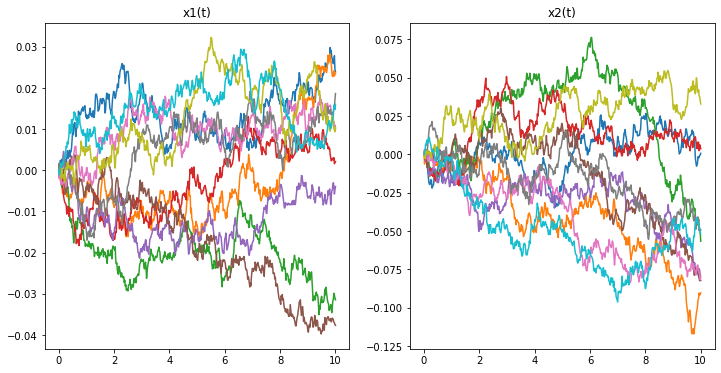

In [10]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

for j in range(M):
    x1_list, x2_list = MC_path(T,dt)
    x1_lists[j] = x1_list
    x2_lists[j] = x2_list
    ax1.plot(t_list,x1_list)
    ax2.plot(t_list,x2_list)
ax1.title.set_text('x1(t)')
ax2.title.set_text('x2(t)')
plt.show()

Solution to Problem 4

In [11]:
delta = 0.5
notional = 50000000

In [12]:
def swap_pv(swap_type, h, delta, notional, T):
    if swap_type == 'payer':
        sign = -1
    else:
        sign = 1
    t_list = np.linspace(0,T,int(T//delta)+1)
    pv = 0
    for i in range(len(t_list)-1):
        t = t_list[i]
        t_plus_1 = t_list[i+1]
        p_t = exp(-a*t-b/2*t**2)
        p_t_plus_1 = exp(-a*t_plus_1-b/2*t_plus_1**2)
        pv += ((1 + h*delta)* p_t_plus_1 - p_t)
    return pv*sign*notional

In [13]:
payer_list = np.zeros(101)
receiver_list = np.zeros(101)
h_list = np.linspace(0,0.1,101)

In [14]:
for l in range(len(h_list)):
    h = h_list[l]
    payer_list[l] = swap_pv('payer',h,delta, notional,T)
    receiver_list[l] = (swap_pv('receiver',h, delta, notional,T))

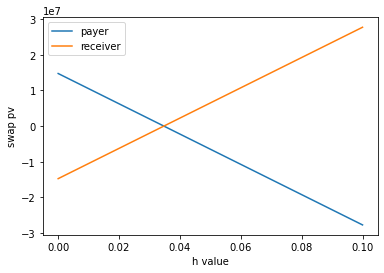

In [15]:
plt.plot(h_list,payer_list, label = 'payer')
plt.plot(h_list,receiver_list, label = 'receiver')
plt.xlabel('h value')
plt.ylabel('swap pv')
plt.legend()
plt.show()

In [16]:
def swap(h):
    return swap_pv('payer',h, delta, notional,T)

In [17]:
h_par = fsolve(swap,0)[0]

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [18]:
print('%.2f%%'% (h_par*100))

3.47%


Solution to Problem 5

In [19]:
def F(t,T,xt):
    
    def A(t,T):
        y_t_1 = y_t(t)
        a = y_t_1[0][0]
        b = y_t_1[0][1]
        c = y_t_1[1][0]
        d = y_t_1[1][1]
        #analytical formula
        return - ((T**2/2-t*T+t**2/2)*a - c/kappa_2**2*(1+np.exp(-kappa_2*(T-t))*(kappa_2*(t-T)-1)) + (T-t)*b/kappa_2
                  + b*(np.exp(-kappa_2*(T-t))-1)/kappa_2**2 + (d*np.exp(-2*kappa_2*(T-t))+d-2*d*np.exp(-kappa_2*(T-t)))/(2*kappa_2**2))
        
    def C(t,T):
        G_t_1 = G(t,T)
        return -G_t_1
    
    A1 = A(t,T)
    C1 = C(t,T)
    
    #P(0,T) = a + b*T
    first_term = exp(-a*T-b/2*T**2)/exp(-a*t-b/2*t**2)
    second_term = exp(A1+np.transpose(C1).dot(xt)[0])
    return first_term*second_term

In [20]:
def beta(t,xt):
    
    for n in range(len(xt)):
        r = a+b*(n*dt)+sum(xt[n])
        
    nt = sum(r[1:int(t/dt)+1])*dt 
    
    #def r_u(u):
        #return a + b*u + x1_t + x2_t
        
    return exp(nt)

In [21]:
def swap_pv_t(swap_type, h, delta, notional,t,T, xt):
    if t == T:
        return 0
    else:
        Ti_list = np.linspace(0,T,int(T//delta)+1)
        if swap_type == 'payer':
            sign = -1
        else:
            sign = 1

        for i in range(len(Ti_list)):
            if Ti_list[i] == t:
                T0 = Ti_list[i]
                Ti_new_list = Ti_list[i+1:]
                break
            elif Ti_list[i] > t:
                T0 = Ti_list[i-1]
                Ti_new_list = Ti_list[i:]
                break

        pv = F(t,Ti_new_list[-1],xt) - beta(t,xt)/beta(T0,xt)
        
        for i in range(len(Ti_new_list)):
            Ti = Ti_new_list[i]
            p_t_Ti = F(t,Ti, xt)
            pv += (h*delta)* p_t_Ti

        return pv*sign*notional

In [22]:
rec_swap_pv = np.zeros((M, int(T/dt)+1))
pay_swap_pv = np.zeros((M, int(T/dt)+1))
for j in tqdm(range(M)):
     for i in range(len(t_list)):
        t = t_list[i]
        x_1 = x1_lists[j][i]
        x_2 = x2_lists[j][i]
        xt = np.array([[x_1],[x_2]])
        rec_swap_pv_t = swap_pv_t('receiver', h_par, delta, notional,t,T,xt)
        rec_swap_pv[j][i] = rec_swap_pv_t
        pay_swap_pv[j][i] = -rec_swap_pv_t

100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


In [23]:
# when t = 0 we check if the pv starts from 0. We can see that it is very close to 0
xt = np.array([[0],[0]])
swap_pv_t('receiver', h_par, delta, notional,0,10,xt)

-1.240327285323417e-08

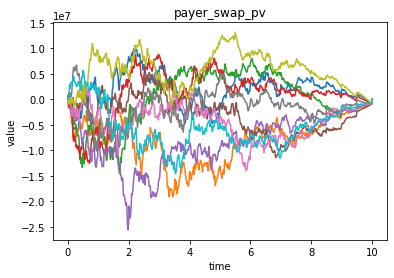

In [24]:
for j in range(M):
    plt.plot(t_list,pay_swap_pv[j])
plt.xlabel('time')
plt.ylabel('value')
plt.title('payer_swap_pv')
plt.show()

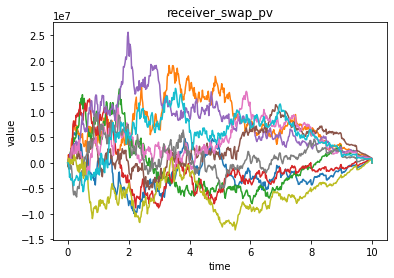

In [25]:
for j in range(M):
    plt.plot(t_list,rec_swap_pv[j])
plt.xlabel('time')
plt.ylabel('value')
plt.title('receiver_swap_pv')
plt.show()

Solution to Problem 6

In [30]:
dt = 1/48
M = 30000
t_list = np.linspace(0,T,int(T/dt)+1)

In [31]:
x1_lists = np.zeros((M, int(T/dt)+1))
x2_lists = np.zeros((M, int(T/dt)+1))
rec_swap_pv = np.zeros((M, int(T/dt)+1))
pay_swap_pv = np.zeros((M, int(T/dt)+1))
for j in tqdm(range(M)):
    x1_list, x2_list = MC_path(T,dt)
    x1_lists[j] = x1_list
    x2_lists[j] = x2_list
for j in tqdm(range(M)):
     for i in range(len(t_list)):
        #print('#######{}/{}; {}/{}'.format(j+1, M, i+1, len(t_list)))
        t = t_list[i]
        x_1 = x1_lists[j][i]
        x_2 = x2_lists[j][i]
        xt = np.array([[x_1],[x_2]])
        rec_swap_pv_t = swap_pv_t('receiver', h_par, delta, notional,t,T, xt)
        rec_swap_pv[j][i] = rec_swap_pv_t
        pay_swap_pv[j][i] = -rec_swap_pv_t
rec_swap_exp = np.where(rec_swap_pv>0, rec_swap_pv, 0)
pay_swap_exp = np.where(pay_swap_pv>0, pay_swap_pv, 0)

100%|██████████| 30000/30000 [8:56:02<00:00,  1.07s/it]      


In [32]:
rec_swap_ee = np.mean(rec_swap_exp, axis = 0)
pay_swap_ee = np.mean(pay_swap_exp, axis = 0)

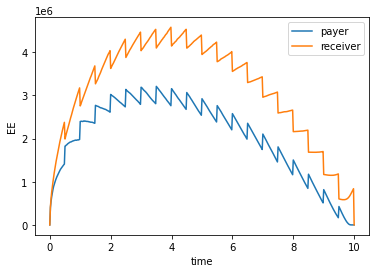

In [33]:
plt.xlabel('time')
plt.ylabel('EE')
plt.plot(t_list, pay_swap_ee, label = 'payer')
plt.plot(t_list, rec_swap_ee, label = 'receiver')
plt.legend()
plt.show()